# Emotion Detection on Twitter Tweets

### This notebook demonstrates the training phase of 3 different models with different architecture and approach. Detailed explanation of them can be found in the attached report. 

Author: Sifat Ahmed <br>
Hiperdyne Corporation <br>
ID: A-1819 <br>
Email: Sifat.austech@outlook.com <br>

## 1. Importing Necessary Libraries ##

In [1]:
import re

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

from nltk import SnowballStemmer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation , Embedding, GlobalMaxPooling1D, Bidirectional

from tensorflow.keras.callbacks import EarlyStopping

D:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2295721102459143248
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3157314764
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5599489828809127357
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


## 2. Reading and Visualization of the dataset

In [3]:
dataset_dir = 'dataset\emotion_dataset.csv'
glove_dir = 'glove\glove.twitter.27B.100d.txt'

In [4]:
nltk_stop_words = list(stopwords.words('english'))

In [5]:
dataset = pd.read_csv(dataset_dir, sep=',', index_col=0)
dataset.head()

,emotion,text
0,anger,fuckin'm transtelecom
1,anger,Working But it's Fridaaaayyyyy
2,anger,Packing I don't like it..
3,anger,I tried to dye my hair and all i got was a blo...
4,anger,&quot;locked up abroad&quot; makes bein half b...


In [6]:
dataset = dataset.sample(frac=1).reset_index(drop=True)
dataset.head()

,emotion,text
0,surprise,@calamitylill Can you send out letters/emails ...
1,surprise,@LenaAlli i dont even know now lenaaa when yo...
2,neutral,@MrsSOsbourne Ozzy isn't following you yet
3,anger,When males in my family try to assign house du...
4,anger,I had not eaten anything for 2 days to be able...


In [7]:
emotion = np.array(dataset['emotion'])

In [8]:
class_values = dataset['emotion'].unique()
print(class_values)

['surprise' 'neutral' 'anger' 'happiness' 'worry' 'hate' 'sadness']


In [9]:
dataset.groupby('emotion')['text'].count()

emotion
anger        1000
happiness    1000
hate         1000
neutral      1000
sadness      1000
surprise     1000
worry        1000
Name: text, dtype: int64

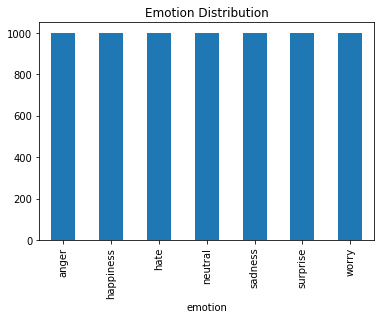

In [10]:
dataset.groupby('emotion')['text'].count().plot(kind='bar' , title= 'Emotion Distribution')

## 3. Preprocessing the Tweets

In [11]:
def preprocess_word(word):
    # Remove punctuation
    word = word.strip('"?!,.():;')
    # Convert more than 2 letter repetitions to 2 letter
    # funnnnny --> funny
    word = re.sub(r'(.)\1+', r'\1\1', word)
    # Remove - & '
    #word = re.sub(r'(-|\')', '', word)
    return word


In [12]:
def is_valid_word(word):
    # Check if word begins with an alphabet
    return (re.search(r'^[a-zA-Z][a-z0-9A-Z\._]*$', word) is not None)


In [13]:
def handle_emojis(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' smile ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' laugh ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' love ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;)', ' affection ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' sad ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' cry ', tweet)
    return tweet

In [14]:
def preprocess_tweet(tweet):
    processed_tweet = []
    # Convert to lower case
    tweet = tweet.lower()
    #HTML removed
    #html_process = BS(tweet, 'html.parser')
    #tweet = html_process.get_tweet()
    
    tweet = re.sub(r"what's", "what is ", tweet)
    tweet = re.sub(r"\'s", " ", tweet)
    tweet = re.sub(r"\'ve", " have ", tweet)
    tweet = re.sub(r"n't", " not ", tweet)
    tweet = re.sub(r"i'm", "i am ", tweet)
    tweet = re.sub(r"\'re", " are ", tweet)
    tweet = re.sub(r"\'d", " would ", tweet)
    tweet = re.sub(r"\'ll", " will ", tweet)
    
    # Replaces URLs with the word URL
    tweet = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', ' ', tweet)
    # Replace @handle with the word USER_MENTION
    tweet = re.sub(r'@[\S]+', ' ', tweet)
    # Replaces #hashtag with hashtag
    tweet = re.sub(r'#(\S+)', r' \1 ', tweet)
    # Remove RT (retweet)
    tweet = re.sub(r'\brt\b', '', tweet)
    # Replace 2+ dots with space
    tweet = re.sub(r'\.{2,}', ' ', tweet)
    # Strip space, " and ' from tweet
    #tweet = tweet.strip(' "\'')
    # Replace emojis with either EMO_POS or EMO_NEG
    tweet = handle_emojis(tweet)
    # Replace multiple spaces with a single space
    tweet = re.sub(r'\s+', ' ', tweet)
    # Striping numbers from the tweet
    tweet = re.sub(r'\d+', '', tweet)
    
    
    words = tweet.split()
    
    stemmer = SnowballStemmer('english')

    #Removing Stop Words and Stemming the Words
    for word in words:
        word = preprocess_word(word)
        if word not in nltk_stop_words and len(word)> 2:
            if is_valid_word(word):
                stemmed_words = stemmer.stem(word)
                processed_tweet.append(word)

    return ' '.join(processed_tweet)

In [15]:
dataset['text'] = dataset['text'].map(lambda x: preprocess_tweet(x))
dataset.head()

,emotion,text
0,surprise,send clients remind
1,surprise,dont even know lenaa going clothes show
2,neutral,ozzy following yet
3,anger,males family try assign house duties exclusive...
4,anger,eaten anything days able pay fine fianct staye...


In [16]:
def plot_model(history):
    # Plot training & validation accuracy values
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


## 4. Label Encoding & Vectorization


In [17]:
label_encoder = LabelEncoder()
encoded_label = label_encoder.fit_transform(emotion)

print(label_encoder.classes_)

label_OneHotEncoder = OneHotEncoder()
encoded_label = label_OneHotEncoder.fit_transform(encoded_label.reshape(-1,1)).toarray()

['anger' 'happiness' 'hate' 'neutral' 'sadness' 'surprise' 'worry']


In [18]:
vocabulary_size = 10000
input_length = 100

In [19]:
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(dataset['text'])
sequences = tokenizer.texts_to_sequences(dataset['text'])
data = pad_sequences(sequences, maxlen = input_length)

In [20]:
train_data, test_data, train_label, test_label = train_test_split(data, encoded_label, test_size = 0.2)

In [21]:
num_classes = len(class_values)
validation_split = 0.1

## 5. Model Creation & Training

### 5.1 Stacked LSTM Model

In [42]:
output_dim = 1000
dense_input = 1000

l1_dropout = 0.2
l1_recurrent_dropout = 0.2

l2_dropout = 0.2
l2_recurrent_dropout = 0.2

l1_lstm_units = 128
l2_lstm_units = 64

validation_split = 0.2
epochs = 20

callback_patience = 2

In [43]:
callback = [EarlyStopping(monitor='val_loss', patience = callback_patience)]

In [44]:
model = Sequential()

model.add(Embedding(vocabulary_size, dense_input, input_length = input_length))
model.add(Dense(dense_input, activation='tanh'))

model.add(LSTM(l1_lstm_units, dropout = l1_dropout, recurrent_dropout = l1_recurrent_dropout, 
                             return_sequences = True, activation='tanh'))
model.add(LSTM(l2_lstm_units, dropout = l2_dropout, recurrent_dropout = l2_recurrent_dropout, 
                             return_sequences = False, activation='tanh'))

model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [45]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 100, 1000)         10000000  
_________________________________________________________________
dense_5 (Dense)              (None, 100, 1000)         1001000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 128)          578048    
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_6 (Dense)              (None, 7)                 455       
Total params: 11,628,911
Trainable params: 11,628,911
Non-trainable params: 0
_________________________________________________________________


D:\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4480 samples, validate on 1120 samples
Epoch 1/20
4480/4480 [==============================] - 109s 24ms/step - loss: 0.3813 - acc: 0.8634 - val_loss: 0.3567 - val_acc: 0.8681
Epoch 2/20
4480/4480 [==============================] - 107s 24ms/step - loss: 0.2825 - acc: 0.8879 - val_loss: 0.3793 - val_acc: 0.8571
Epoch 3/20
4480/4480 [==============================] - 109s 24ms/step - loss: 0.1676 - acc: 0.9370 - val_loss: 0.4564 - val_acc: 0.8403


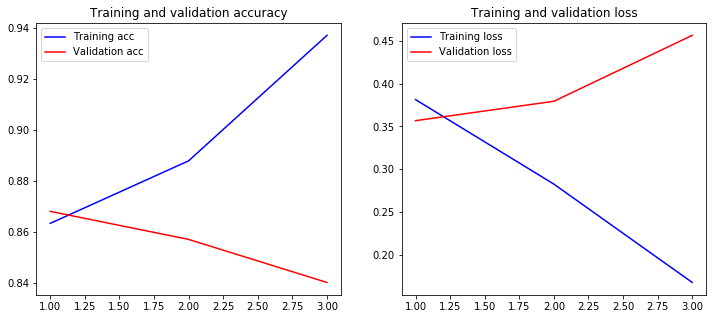

In [46]:
history = model.fit(train_data, train_label, validation_split = validation_split, epochs=epochs, 
                    shuffle = True, callbacks = callback)

plot_model(history)

In [50]:
model.evaluate(test_data, test_label, verbose = 1)

1400/1400 [==============================] - 15s 11ms/step


[0.43814087884766717, 0.8437755152157375]

In [51]:
model.save('saved_model\model_1.h5')

### 5.2 Stacked LSTM with 1D Convolutions

In [52]:
output_dim = 100
dense_input = 1000

dropout = 0.3

conv1D_filters = 100
conv1D_kernel_size = 5

pool_size = 4

l1_dropout = 0.2
l1_recurrent_dropout = 0.2

l2_dropout = 0.2
l2_recurrent_dropout = 0.2

l1_lstm_units = 64
l2_lstm_units = 32

In [56]:
model_conv = Sequential()

model_conv.add(Embedding(vocabulary_size, output_dim, input_length = input_length, trainable=False))
model_conv.add(Dropout(dropout))
#model_conv.add(Dense(output_dim, activation='tanh'))

model_conv.add(Conv1D(filters = conv1D_filters, kernel_size = conv1D_kernel_size, activation = 'relu'))
model_conv.add(MaxPooling1D(pool_size = pool_size))

model_conv.add(LSTM(l1_lstm_units , dropout = l1_dropout, return_sequences=True, activation='tanh'))
model_conv.add(LSTM(l2_lstm_units , dropout = l2_dropout, return_sequences=False, activation='relu'))

model_conv.add(Dense(num_classes, activation='softmax'))
model_conv.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [57]:
model_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 100)           50100     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 24, 100)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 24, 64)            42240     
_________________________________________________________________
lstm_9 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_9 (Dense)              (None, 7)                 231       
Total para

Train on 4480 samples, validate on 1120 samples
Epoch 1/20
4480/4480 [==============================] - 34s 8ms/step - loss: 0.4072 - acc: 0.8578 - val_loss: 0.4003 - val_acc: 0.8594
Epoch 2/20
4480/4480 [==============================] - 28s 6ms/step - loss: 0.3998 - acc: 0.8595 - val_loss: 0.3986 - val_acc: 0.8599
Epoch 3/20
4480/4480 [==============================] - 31s 7ms/step - loss: 0.3963 - acc: 0.8604 - val_loss: 0.3946 - val_acc: 0.8608
Epoch 4/20
4480/4480 [==============================] - 29s 6ms/step - loss: 0.3940 - acc: 0.8609 - val_loss: 0.3957 - val_acc: 0.8594
Epoch 5/20
4480/4480 [==============================] - 30s 7ms/step - loss: 0.3890 - acc: 0.8622 - val_loss: 0.3918 - val_acc: 0.8607
Epoch 6/20
4480/4480 [==============================] - 30s 7ms/step - loss: 0.3837 - acc: 0.8633 - val_loss: 0.3919 - val_acc: 0.8611
Epoch 7/20
4480/4480 [==============================] - 35s 8ms/step - loss: 0.3768 - acc: 0.8649 - val_loss: 0.3928 - val_acc: 0.8617


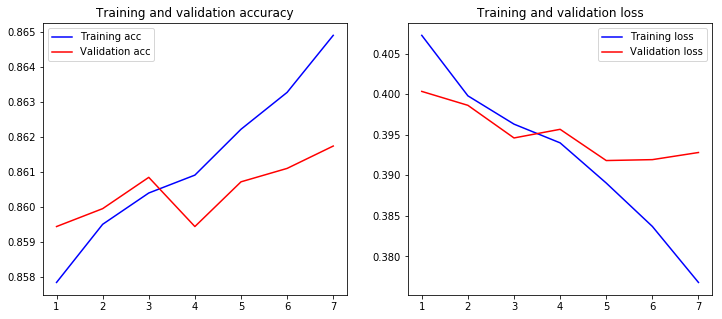

In [58]:
history = model_conv.fit(train_data, train_label, validation_split = validation_split, epochs = epochs, 
                         shuffle = True, callbacks = callback)

plot_model(history)

In [59]:
model_conv.save('saved_model\model_conv.h5')

In [60]:
embeddings_index = dict()
f = open(glove_dir, encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [61]:
embedding_matrix = np.zeros((vocabulary_size, output_dim))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [62]:
output_dim = 100
dense_input = 1000

dropout = 0.3

conv1D_filters = 100
conv1D_kernel_size = 4

pool_size = 5

l1_dropout = 0.2
l1_recurrent_dropout = 0.2

l2_dropout = 0.2
l2_recurrent_dropout = 0.2

l1_lstm_units = 64
l2_lstm_units = 32

### 5.3 Stacked LSTM with 1D Convolutions on pretrained vector

In [63]:
model_glove = Sequential()
model_glove.add(Embedding(vocabulary_size, output_dim, input_length = input_length, 
                          weights=[embedding_matrix], trainable=False))
model_glove.add(Dropout(dropout))

model_glove.add(Dense(output_dim, activation='tanh'))

model_glove.add(Conv1D(filters = conv1D_filters, kernel_size = conv1D_kernel_size, 
                       activation='tanh'))
model_glove.add(MaxPooling1D(pool_size = pool_size))

model_glove.add(LSTM(l1_lstm_units , dropout = l1_dropout,
                     return_sequences=True, activation='tanh'))
model_glove.add(LSTM(l2_lstm_units , dropout = l2_dropout,
                     return_sequences=False , activation='tanh'))

model_glove.add(Dense(7, activation='softmax'))

model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [64]:
model_glove.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
dense_10 (Dense)             (None, 100, 100)          10100     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 97, 100)           40100     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 19, 100)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 19, 64)            42240     
_________________________________________________________________
lstm_11 (LSTM)               (None, 32)                12416     
__________

Train on 4480 samples, validate on 1120 samples
Epoch 1/20
4480/4480 [==============================] - 22s 5ms/step - loss: 0.3940 - acc: 0.8600 - val_loss: 0.3732 - val_acc: 0.8652
Epoch 2/20
4480/4480 [==============================] - 22s 5ms/step - loss: 0.3681 - acc: 0.8658 - val_loss: 0.3686 - val_acc: 0.8667
Epoch 3/20
4480/4480 [==============================] - 22s 5ms/step - loss: 0.3595 - acc: 0.8676 - val_loss: 0.3608 - val_acc: 0.8688
Epoch 4/20
4480/4480 [==============================] - 22s 5ms/step - loss: 0.3553 - acc: 0.8678 - val_loss: 0.3622 - val_acc: 0.8666
Epoch 5/20
4480/4480 [==============================] - 21s 5ms/step - loss: 0.3516 - acc: 0.8695 - val_loss: 0.3569 - val_acc: 0.8696
Epoch 6/20
4480/4480 [==============================] - 18s 4ms/step - loss: 0.3476 - acc: 0.8707 - val_loss: 0.3609 - val_acc: 0.8689
Epoch 7/20
4480/4480 [==============================] - 19s 4ms/step - loss: 0.3433 - acc: 0.8712 - val_loss: 0.3574 - val_acc: 0.8702


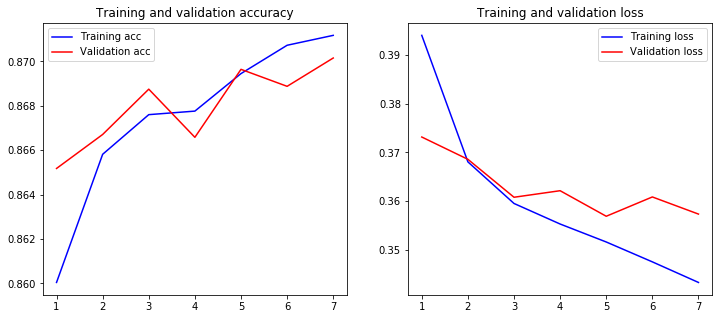

In [65]:
history = model_glove.fit(train_data, train_label, validation_split = validation_split, epochs = epochs, 
                          shuffle = True, callbacks = callback)

plot_model(history)

In [66]:
model_glove.save('saved_model\model_glove.h5')

In [67]:
model_glove.evaluate(test_data, test_label, verbose = 1)

1400/1400 [==============================] - 2s 1ms/step


[0.3533576597486224, 0.8697959327697754]

In [68]:
model_conv.predict(test_data[0:1])

array([[0.02422823, 0.16307601, 0.15094452, 0.17102222, 0.1644995 ,
        0.14636314, 0.17986636]], dtype=float32)

## 6. Testing the all the above models with a random text

In [71]:
test_text = 'I was happy but then I am not happy'
test_text = pd.Series(test_text)

sequences = tokenizer.texts_to_sequences(test_text)
data = pad_sequences(sequences, maxlen = input_length)

In [74]:
label_encoder.classes_[np.argmax(model.predict(data))]

'happiness'

In [75]:
label_encoder.classes_[np.argmax(model_conv.predict(data))]

'happiness'

In [76]:
label_encoder.classes_[np.argmax(model_glove.predict(data))]

'happiness'

In [77]:
print(label_encoder.classes_)

['anger' 'happiness' 'hate' 'neutral' 'sadness' 'surprise' 'worry']


In [78]:
np.around(model.predict(data), decimals = 2)

array([[0.  , 0.93, 0.  , 0.02, 0.01, 0.02, 0.01]], dtype=float32)

In [79]:
np.around(model_conv.predict(data), decimals = 2)

array([[0.06, 0.19, 0.15, 0.14, 0.16, 0.14, 0.16]], dtype=float32)

In [80]:
np.around(model_glove.predict(data), decimals = 2)

array([[0.01, 0.59, 0.04, 0.07, 0.1 , 0.13, 0.07]], dtype=float32)